In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
#這邊是先將資料載入後做統一格式的前處理
# https://www.investing.com/etfs/yuanta-p-shares-taiwan-top-50
Data=pd.read_csv("0050 ETF Stock Price History.csv") #載入csv
#Data #show data

In [3]:
Data['Date'] = pd.to_datetime(Data['Date']) #將原始資料的時間轉為pandas的Time Series序列
Data.index=Data.Date
Data=Data.drop(['Date'],axis=1)
Data=Data.iloc[::-1] #因為原始資料的前後順序相反了 所以將資料倒過來
Data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2014-01-02,58.55,58.70,58.75,58.35,10.76M,-0.26%
2014-01-03,57.85,58.45,58.45,57.70,14.51M,-1.20%
2014-01-06,57.70,57.75,57.95,57.55,14.87M,-0.26%
2014-01-07,57.70,57.75,57.90,57.70,13.13M,0.00%
2014-01-08,57.80,57.70,57.95,57.70,7.61M,0.17%
...,...,...,...,...,...,...
2023-10-30,122.00,122.40,122.85,121.75,9.79M,-0.25%
2023-10-31,121.15,122.40,122.45,121.10,11.95M,-0.70%
2023-11-01,121.75,122.00,122.15,121.25,4.85M,0.50%


In [4]:
#vol. string改為float
def convert_vol_to_int(vol_str):
    multiplier = 1
    if 'K' in vol_str:
        multiplier = 10**3
    elif 'M' in vol_str:
        multiplier = 10**6
    elif 'B' in vol_str:
        multiplier = 10**9
    return int(float(vol_str.replace('K', '').replace('M', '').replace('B', '')) * multiplier)

Data['Vol.'] = Data['Vol.'].apply(convert_vol_to_int)


In [5]:
# change % 改為float
Data['Change %'] = Data['Change %'].str.rstrip('%').astype('float') / 100.0

In [6]:
# 假設有一個包含特徵和價格的資料框 Data
features = ['Open', 'High', 'Low', 'Vol.', 'Change %']
X = Data[features]
y = Data['Price']

'''
# 分割方法要一致，因此改成跟lstm以時間的方法下去分
# 將資料分為訓練和測試集
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
'''

# 分割訓練集和測試集
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [7]:
X_train

,Open,High,Low,Vol.,Change %
Date,,,,,
2014-01-02,58.70,58.75,58.35,10760000,-0.0026
2014-01-03,58.45,58.45,57.70,14510000,-0.0120
2014-01-06,57.75,57.95,57.55,14870000,-0.0026
2014-01-07,57.75,57.90,57.70,13130000,0.0000
2014-01-08,57.70,57.95,57.70,7610000,0.0017
...,...,...,...,...,...
2021-11-03,136.40,137.00,136.40,2400000,0.0026
2021-11-04,137.25,137.50,136.15,2660000,-0.0033
2021-11-05,137.10,138.20,136.80,11660000,0.0143


In [8]:
# 建立並訓練隨機森林回歸模型
model = RandomForestRegressor()
model.fit(X_train, y_train)

# 預測價格
predictions = model.predict(X_test)

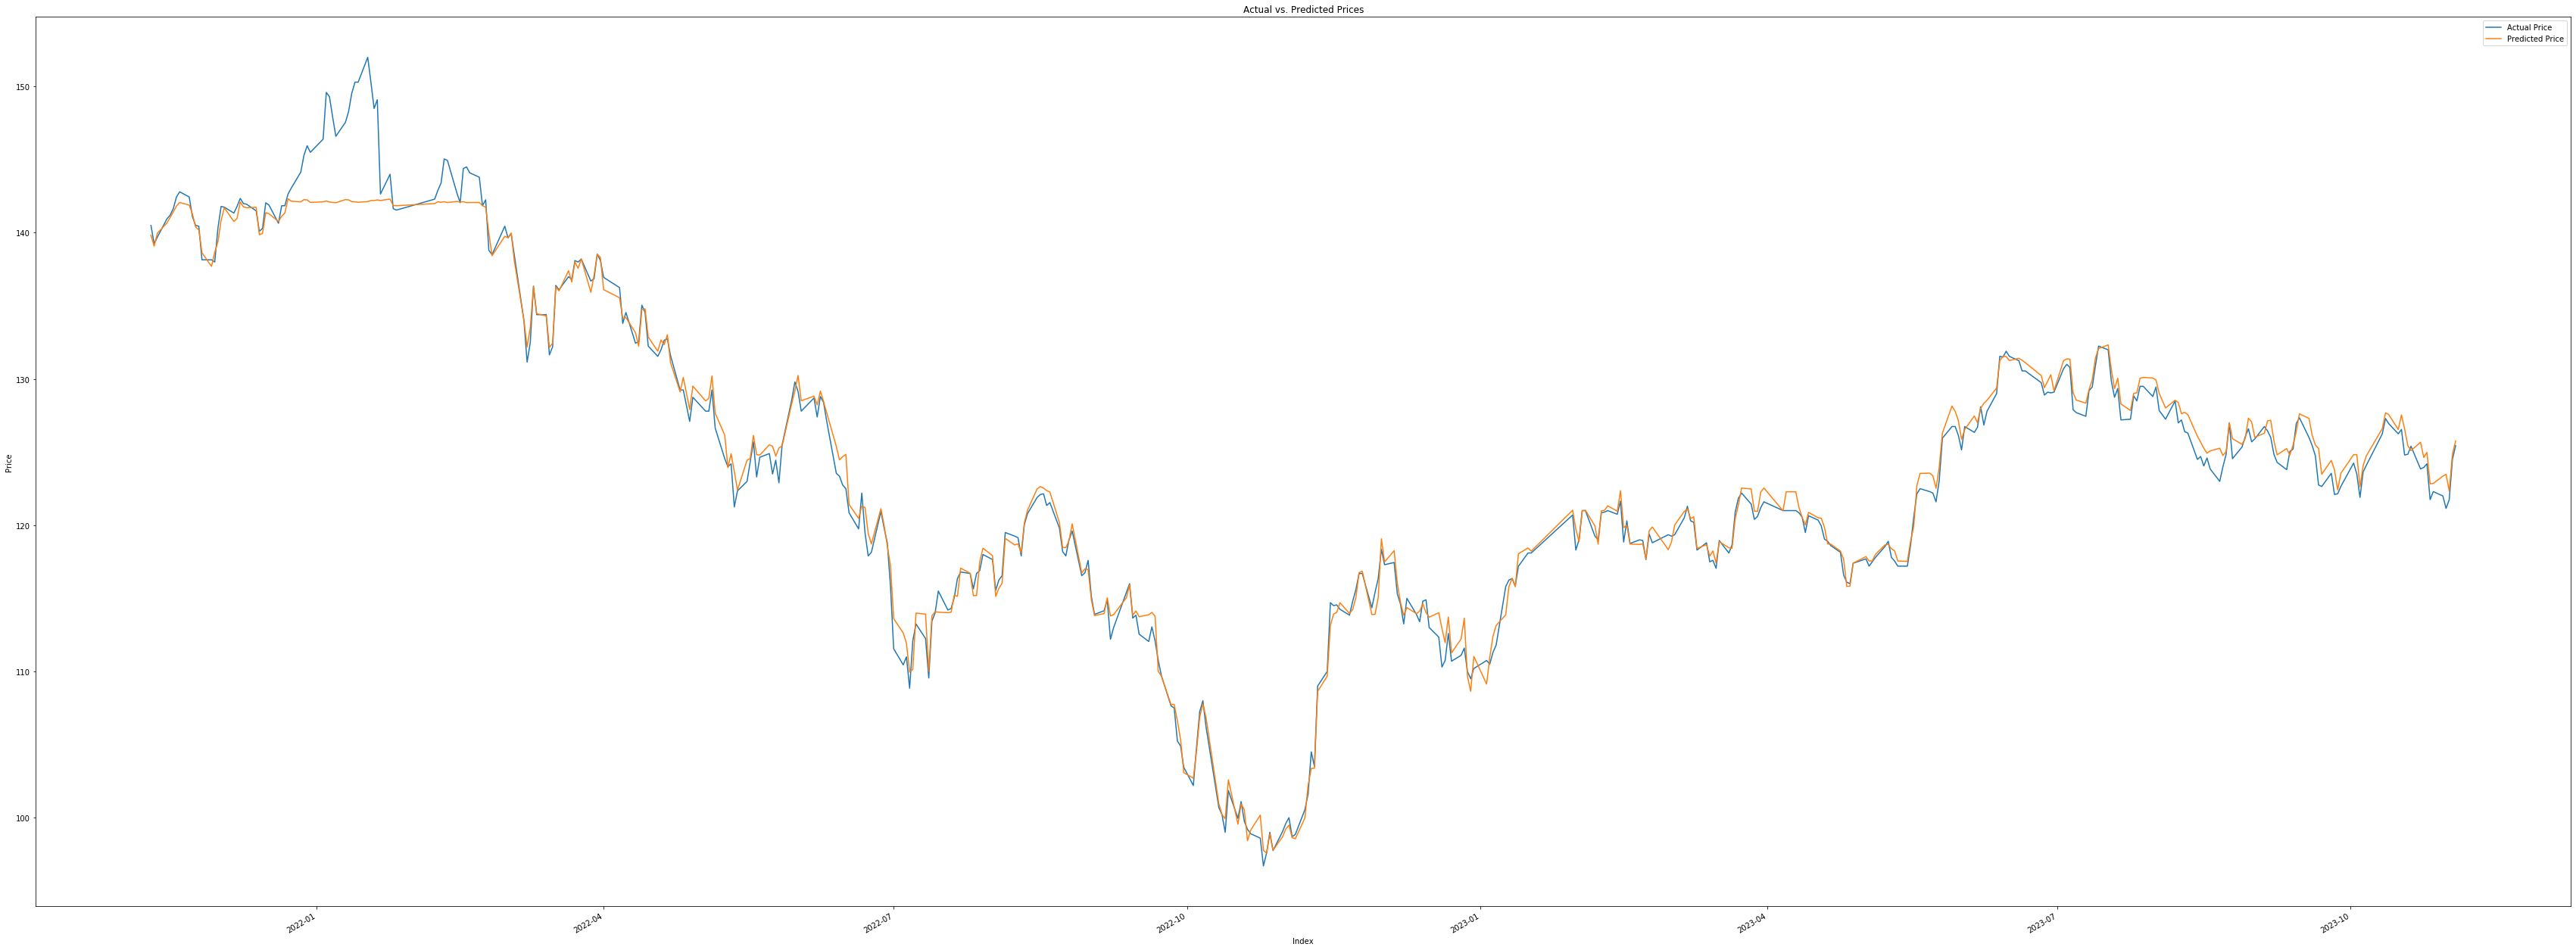

In [9]:
# 合併實際價格和預測價格到同一個資料框
result_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': predictions})

# 繪製價格對比圖
result_df.plot(figsize=(60,24), title='Actual vs. Predicted Prices')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.show()

In [10]:
# 計算 R2 分數
r2_score_value = r2_score(y_test, predictions)
print(f'R2 Score: {r2_score_value}')

R2 Score: 0.9832133053225346


# golden cross return test

In [11]:
# 交易模型的回測函數
def Backtesting(Data):
    # 初始化總收益
    TotalReturn = 1  # 初始總回報率設為1表示無變化
    ReturnList = []  # 用來存放每次交易的回報率的列表
    # 加入回報曲線
    TotalReturnList = []

    # 從輸入的資料中選取進場點和出場點
    EntryList = Data[Data['Entry'] == True]
    ExitList = Data[Data['Exit'] == True]

    # 迭代處理每次進場
    for i in range(len(EntryList) - 1):
        # 進場點的價格和時間
        EntryPrice = EntryList.Price.values[i]
        EntryTime = EntryList.index[i]
        # 出場點的價格和時間
        ExitPrice = ExitList.loc[EntryTime:].Price.values[0]
        ExitTime = ExitList.loc[EntryTime:].index[0]

        # 計算該次交易的回報率並乘到總回報率
        Return = (ExitPrice - EntryPrice) / EntryPrice
        TotalReturn *= (1 + Return)
        
        # 加入回報曲線
        TotalReturnList.append(TotalReturn)
        # 將該次交易的回報率加入列表
        ReturnList.append(Return)

    # 將回報率列表轉換為DataFrame格式
    ReturnList = pd.DataFrame(ReturnList)
    # 將列名設定為'Return'
    ReturnList['Return'] = ReturnList[0]
    # 刪除原來的列
    ReturnList = ReturnList.drop([0], axis=1)
    # 將索引設定為進場點的時間
    ReturnList.index = EntryList.index[0:-1]
    # 繪製回報率曲線
    ReturnList.plot()

    # 加入回報曲線圖 
    # !(第一點不是一)
    TotalReturnList = pd.DataFrame(TotalReturnList)
    TotalReturnList['Return'] = TotalReturnList[0] 
    TotalReturnList = TotalReturnList.drop([0], axis=1)
    TotalReturnList.index = EntryList.index[0:-1]
    TotalReturnList.plot()

    # 計算總回報率轉換為總獲利百分比
    TotalReturn = (TotalReturn - 1) * 100

    # 返回總獲利百分比
    return TotalReturn

In [15]:
# 套用預測結果到 golden cross 回測方法
def GoldenCrossBacktesting(Data, predictions):
    # 加入預測結果到資料框
    Data['Predicted'] = 0  # 先初始化一列
    Data.loc[X_test.index, 'Predicted'] = predictions  # 加入預測結果到相對應的位置

    # 計算均線
    fast = Data['Predicted'].rolling(5).mean()
    slow = Data['Predicted'].rolling(20).mean()

    # 計算進場和出場點
    Entry = (fast > slow) & (fast.shift() < slow.shift())
    Exit = (fast < slow) & (fast.shift() > slow.shift())

    # 加入進場和出場點到資料框
    Data['Entry'] = Entry
    Data['Exit'] = Exit

    # 進行回測
    total_return = Backtesting(Data)

    # 返回總回報率
    return total_return

Total Return: 3.7938930872421395%


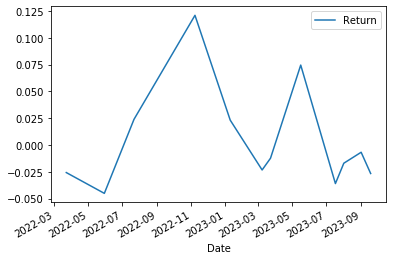

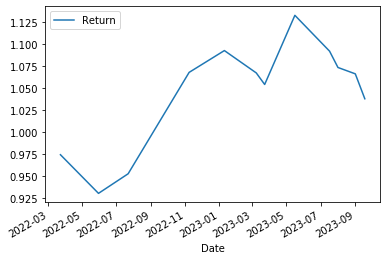

In [16]:
# 呼叫回測函數
total_return = GoldenCrossBacktesting(Data, predictions)

# 顯示回報率
print(f'Total Return: {total_return}%')
